In [1]:
import IPython.display as ipd
import pandas as pd
import numpy as np
import librosa
import librosa.display
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import os

def emotion_finder(file_name):
    emotion = {
        "01": "neutral",
        "02": "calm",
        "03": "happy",
        "04": "sad",
        "05": "angry",
        "06": "fearful",
        "07": "disgust",
        "08": "surprised"
    }
    index = file_name.split("-")[2]
    return emotion.get(index, "unknown")


In [3]:
emotions_list = []
actor_names = []
file_names = []

# Two main folders
folders = [
    '/Users/yathamlohithreddy/Desktop/vscodefloder/marsproject/Audio_Speech_Actors_01-24',
    '/Users/yathamlohithreddy/Desktop/vscodefloder/marsproject/Audio_Song_Actors_01-24'

]


In [4]:
# Go through each top-level folder
for pre in folders:
    for actor_name in os.listdir(pre):
        actor_path = os.path.join(pre, actor_name)
        if not os.path.isdir(actor_path):
            continue  # Skip files
        actor_names.append(actor_name)
        for filename in os.listdir(actor_path):
            if filename.endswith(".wav"):
                full_path = os.path.join(actor_path, filename)
                file_names.append(full_path)
                emotion = emotion_finder(filename)
                emotions_list.append(emotion)

Number of files: 2452
Number of emotions: 2452
emotion
angry        376
fearful      376
sad          376
happy        376
calm         376
disgust      192
surprised    192
neutral      188
Name: count, dtype: int64
/Users/yathamlohithreddy/Desktop/vscodefloder/marsproject/Audio_Speech_Actors_01-24/Actor_16/03-01-05-01-02-01-16.wav


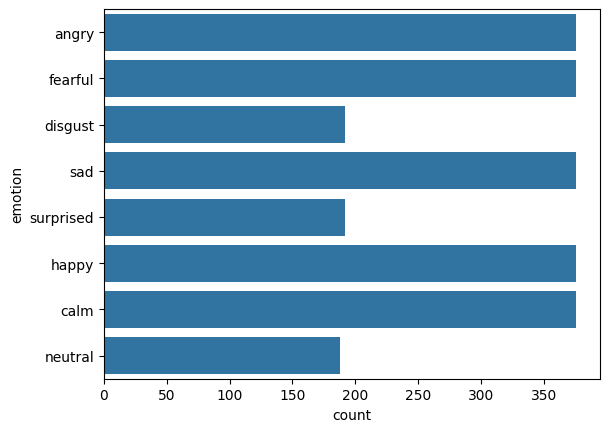

In [5]:

print("Number of files:", len(file_names))
print("Number of emotions:", len(emotions_list))
df = pd.DataFrame()
df["file_name"] = file_names
df["emotion"] = emotions_list
print(df["emotion"].value_counts())
sns.countplot(df["emotion"])
print(df["file_name"][0])

In [6]:
from sklearn.utils import resample


df = pd.DataFrame({"file_path": file_names, "emotion": emotions_list})
max_count = df['emotion'].value_counts().max()
balanced_df = pd.concat([
    resample(df[df.emotion == e], replace=True, n_samples=max_count, random_state=42)
    for e in df['emotion'].unique()]).sample(frac=1, random_state=42)
df = balanced_df
balanced_df["emotion"].value_counts()


emotion
fearful      376
calm         376
disgust      376
neutral      376
angry        376
happy        376
surprised    376
sad          376
Name: count, dtype: int64

In [7]:
def mfcc_values(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc


def delta_values(file_name):
    mfcc = mfcc_values(file_name)
    delta_mfcc =  librosa.feature.delta(mfcc)
    return delta_mfcc


def log_mel_values(file_path, duration=3, offset=0.5, n_mels=128):
    y, sr = librosa.load(file_path, duration=duration, offset=offset)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec)
    log_mel_mean = np.mean(log_mel_spec.T, axis=0)
    
    return log_mel_mean


def zcr_values(file_name):
    sig ,sr = librosa.load(file_name,duration=3, offset = 0.5)
    zcr = np.mean(librosa.feature.zero_crossing_rate(sig).T, axis=0)
    return zcr


def spectral_features(file_path, duration=3, offset=0.5):
    y, sr = librosa.load(file_path, duration=duration, offset=offset)
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    flatness = np.mean(librosa.feature.spectral_flatness(y=y))
    spectral_features = np.hstack([centroid, bandwidth, rolloff, flatness, contrast])

    return spectral_features


def extract_features(file_name):
    mfcc = mfcc_values(file_name)
    delta = delta_values(file_name)
    log_mel = log_mel_values(file_name)
    zcr = zcr_values(file_name)
    spectral = spectral_features(file_name)
    all_features = np.hstack([mfcc,delta,log_mel,zcr,spectral])
    return all_features


features = []
labels = []

for i, row in df.iterrows():
    f = extract_features(row['file_path'])
    features.append(f)
    labels.append(row['emotion'])

X = np.array(features)
y = np.array(labels)




In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



[[68  0  1  2  0  0  0  4]
 [ 0 68  1  0  1  2  3  0]
 [ 0  0 69  1  1  0  1  3]
 [ 0  1  0 66  1  0  6  2]
 [ 1  3  4  2 62  1  1  1]
 [ 0  2  0  0  0 73  0  0]
 [ 0  3  1  3  1  4 60  4]
 [ 0  2  0  0  0  0  0 73]]
              precision    recall  f1-score   support

       angry       0.99      0.91      0.94        75
        calm       0.86      0.91      0.88        75
     disgust       0.91      0.92      0.91        75
     fearful       0.89      0.87      0.88        76
       happy       0.94      0.83      0.88        75
     neutral       0.91      0.97      0.94        75
         sad       0.85      0.79      0.82        76
   surprised       0.84      0.97      0.90        75

    accuracy                           0.90       602
   macro avg       0.90      0.90      0.90       602
weighted avg       0.90      0.90      0.89       602



In [9]:
import os
import joblib

# Ensure directory exists
os.makedirs("model", exist_ok=True)

# Save model
joblib.dump(clf, "model/trained_model.pkl")

# Save LabelEncoder


print("✅ Model  saved successfully.")


✅ Model  saved successfully.


In [10]:
from sklearn.preprocessing import LabelEncoder
import pickle
import os

# Your list of string labels (e.g., from your dataset)
emotions_list = ['happy', 'angry', 'sad', 'calm', 'fearful', 'happy', 'sad']  # example

# Encode labels
le = LabelEncoder()
Y = le.fit_transform(emotions_list)

# Make sure model folder exists
os.makedirs("model", exist_ok=True)

# Save encoder to disk
with open("model/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("✅ LabelEncoder saved to model/label_encoder.pkl")



✅ LabelEncoder saved to model/label_encoder.pkl
